In [15]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

In [16]:
def build_cost_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliZ(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

cost_h = build_cost_h(n_qubits)
print(cost_h)

driver_h = build_driver_h(n_qubits)
print(driver_h)

def build_comm_h(n):
    coeffs = [2.0] * n
    ops = [qml.PauliY(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)
comm_h = build_comm_h(n_qubits)
print(comm_h)


-1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
2.0 * Y(0) + 2.0 * Y(1) + 2.0 * Y(2) + 2.0 * Y(3)


In [17]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

In [18]:
def build_ansatz(cost_h, driver_h, delta_t): #Define a method to construct the ansatz circuit for solving the MaxClique problem
    def ansatz(beta, **kwargs): #Inside it define a function that takes a list of feedback parameters beta
        layers = len(beta) #Use the length of beta to determine the number of evolution layers
        for w in dev.wires:
            qml.Hadamard(wires=w) #Apply Hadamard gates to all qubits to prepare the uniform superposition initial state.
        qml.layer( #Apply the falqon_layer function in a loop,using each beta_k along with H_c,H_d and time delta_t
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz #return the ansatz function for use in the quantum circuit.


def expval_circuit(beta, measurement_h): #run the circuit and returns an expectation value.
    ansatz = build_ansatz(cost_h, driver_h, delta_t) #Construct the ansatz using the cost and driver Hamiltonians.
    ansatz(beta)  #apply the ansatz to the circuit using feedback parameters beta
    return qml.expval(measurement_h) #return the expecatation value of the specified measurement Hamiltonian.

In [19]:
def main_function(n_qubits, n, beta_1, delta_t, dev):
    cost_h = build_cost_h(n_qubits)
    driver_h = build_driver_h(n_qubits)
    comm_h = build_comm_h(n_qubits)


    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    beta = [beta_1]
    energies = []

    for i in range(n):
        next_beta = -1 *delta_t* cost_fn(beta, measurement_h=comm_h)
        beta.append(next_beta)
        energy = cost_fn(beta, measurement_h=cost_h)
        energies.append(energy)

    return beta, energies

In [20]:
n = 40
beta_1 = 0.0
delta_t = 0.03
dev = qml.device("default.qubit", wires=n_qubits)
res_beta, res_energies = main_function(n_qubits, n, beta_1, delta_t, dev) 

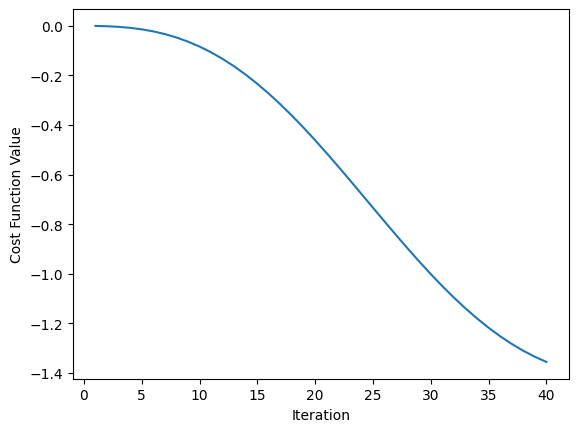

In [21]:
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()